In [ ]:
!pip install pytorch-adapt
!pip install pandas==1.3.5

In [ ]:
# download logits
# !wget -O dann_mnist_logits.pkl https://cornell.box.com/shared/static/skt4oosehki3cvp9hh2w89b1bdiygi3s
# !wget -O adda_mnist_logits.pkl https://cornell.box.com/shared/static/ubreh2boy8fpxqvtcne4tlj6c5iwobao
# !wget -O vada_mnist_logits.pkl https://cornell.box.com/shared/static/nvx0r36npbecrx0dnkea0nvxivkeurf3

# download validation scores and accuracies
!wget -O dann_mnist_accs.pkl https://cornell.box.com/shared/static/xnrr2wx9z08c5nefl0y7vwo3jehe40q4
!wget -O adda_mnist_accs.pkl https://cornell.box.com/shared/static/ffdke8qlw73mlwzifyubwwnn4kma96ts
!wget -O vada_mnist_accs.pkl https://cornell.box.com/shared/static/6mei6t7oqui791qy8vgp3a0nepe9ko9e

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import tqdm
from pytorch_adapt.validators import AccuracyValidator, IMValidator, SNDValidator

In [2]:
def get_acc(row, split, validator, device):
    logits = torch.from_numpy(getattr(row, f"{split}_logits")).to(device)
    labels = torch.from_numpy(getattr(row, f"{split}_labels")).to(device)
    preds = F.softmax(logits, dim=1)
    return validator.score(src_val={"preds": preds, "labels": labels})


def get_im(row, validator, device):
    logits = torch.from_numpy(row.target_logits).to(device)
    return validator.score(target_train={"logits": logits})


def get_snd(row, validator, device):
    logits = torch.from_numpy(row.target_logits).to(device)
    preds = F.softmax(logits, dim=1)
    return validator.score(target_train={"preds": preds})


def compute_acc(algo):
    df = pd.read_pickle(f"{algo}_mnist_logits.pkl")

    all_exp_nums = []
    all_epochs = []
    all_src_accs = []
    all_target_accs = []
    all_im = []
    all_snd = []
    device = torch.device("cuda")

    AV = AccuracyValidator(torchmetric_kwargs={"average": "macro", "num_classes": 10})
    IMV = IMValidator()
    SNDV = SNDValidator()

    for row in tqdm.tqdm(df.itertuples(), total=df.shape[0]):
        all_exp_nums.append(row.exp_num)
        all_epochs.append(row.epoch)
        all_src_accs.append(get_acc(row, "src", AV, device))
        all_target_accs.append(get_acc(row, "target", AV, device))
        all_im.append(get_im(row, IMV, device))
        all_snd.append(get_snd(row, SNDV, device))

    return pd.DataFrame(
        {
            "exp_num": all_exp_nums,
            "epoch": all_epochs,
            "src_acc": all_src_accs,
            "target_acc": all_target_accs,
            "im": all_im,
            "snd": all_snd,
        }
    )


def compute_acc_and_save(algo):
    df = compute_acc(algo)
    df.to_pickle(f"{algo}_mnist_accs.pkl", protocol=4)

In [3]:
df = []
for algo in ["dann", "adda", "vada"]:
    #     compute_acc_and_save(algo)
    curr_df = pd.read_pickle(f"{algo}_mnist_accs.pkl")
    df.append(curr_df.assign(algo=algo))
df = pd.concat(df, ignore_index=True)

best validation score 9.105
target accuracy 0.1


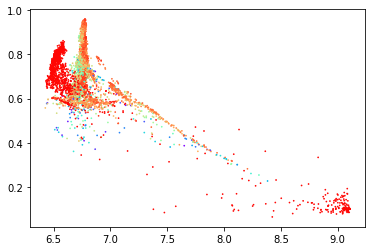

In [4]:
def filter_by_src_acc(df, src_threshold):
    df = df.round(4)
    pretrained_src_acc = np.round(0.9949950575828552, 4)
    return df[(df["src_acc"] / pretrained_src_acc) >= src_threshold]


def scatter_plot(df, x, y, c):
    plt.scatter(df[x], df[y], c=df[c], s=0.5, cmap="rainbow")


def filter_and_plot(df, validator, src_threshold, algos):
    df = filter_by_src_acc(df, src_threshold)
    df = df[df["algo"].isin(algos)]
    scatter_plot(df, validator, "target_acc", "src_acc")
    return df.loc[df[validator].idxmax()]


validator = "snd"
algos = ["dann", "adda", "vada"]
best_row = filter_and_plot(df, validator, 0.98, algos)
print("best validation score", best_row[validator])
print("target accuracy", best_row["target_acc"])